In [2]:
from numpy.random import normal
from math import sqrt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import os
from torch.autograd import Variable
import torch.utils.data as Data
from torch.utils.data import Dataset
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import torchvision
import warnings
torch.set_default_tensor_type(torch.FloatTensor)
import copy
import random
warnings.filterwarnings("ignore")

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
setup_seed(20)

In [4]:
def make_txt_file(path):
    
    # Classes: train, eval, test
    img_path=os.path.join(path,'TrainVal_images')
    label_path=os.path.join(path,'TrainVal_parsing_annotations')
    train_data=open('train.txt', 'w')
    eval_data=open('eval.txt','w')
    test_data=open('test.txt','w')
    train_data.truncate()
    eval_data.truncate()
    test_data.truncate()
    train_id=open(os.path.join(path,'train_id.txt'))
    val_id=open(os.path.join(path,'val_id.txt'))
    
    train_data_path=os.path.join(img_path,'train_images')
    val_data_path=os.path.join(img_path,'val_images')
    train_label_path=os.path.join(label_path,'train_segmentations')
    val_label_path=os.path.join(label_path,'val_segmentations')
    
    lines=train_id.readlines()
    count=0
    for line in lines:
        line=line.strip()
        name=os.path.join(train_data_path,line+'.jpg')+'*'+os.path.join(train_label_path,line+'.png')+'\n'
        train_data.write(name)
        count+=1
        if count>=4000:
            break
    train_data.close()
    train_id.close()
    
    lines=val_id.readlines()
    s=0
    count=0
    for line in lines:
        line=line.strip()
        name=os.path.join(val_data_path,line+'.jpg')+'*'+os.path.join(val_label_path,line+'.png')+'\n'
        if s%2==0:
            eval_data.write(name)
        else:
            test_data.write(name)
        s+=1
        
        count+=1
        if count>=2000:
            break
            
    val_id.close() 
    eval_data.close()
    test_data.close()
                
    


In [5]:
class MyDataSet(Dataset):
    def __init__(self, dataset_type, transform=None,update_dataset=False):
        """
        dataset_type: [train, eval, test]
        """
 
        dataset_path = '/kaggle/input/pil-data/LIP'

        read_path=''
 
        if update_dataset:
            make_txt_file(dataset_path) 
 
        self.transform = transform
        self.sample_list = list()
        self.dataset_type = dataset_type
        f = open(os.path.join(read_path , self.dataset_type + '.txt'))
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()
 
    def __getitem__(self, index):
        item = self.sample_list[index]
        img = Image.open(item.split('*')[0]).convert('RGB')       
        label = Image.open(item.split('*')[1]).convert('L')
        
        if self.transform is not None:
            img,label = self.transform(img,label)
           
        return img, label
 
    def __len__(self):
        return len(self.sample_list)

In [6]:
def train_transform(data,label):
    data=transforms.functional.pad(data,padding=((max(data.size)-data.size[0])//2,(max(data.size)-data.size[1])//2))
    label=transforms.functional.pad(label,padding=((max(label.size)-label.size[0])//2,(max(label.size)-label.size[1])//2))
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))   
    
    
#     if np.random.rand()>0.5:
#         data=transforms.functional.hflip(data)
#         label=transforms.functional.hflip(label)
#     if np.random.rand()>0.5:
#         data=transforms.functional.vflip(data)
#         label=transforms.functional.vflip(label)
        
#     angle = transforms.RandomRotation.get_params([-45, 45]) 
#     data=transforms.functional.rotate(data,angle)
#     label=transforms.functional.rotate(label,angle)
    

    data=transforms.functional.to_tensor(data).float()
    
    label=np.array(label,dtype='int64')
    label=torch.from_numpy(label)
    return data,label

def test_transfrom(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))
    data=transforms.functional.to_tensor(data).float()

    label=np.array(label,dtype='int64')
    label=torch.from_numpy(label)
    return data,label
    

In [7]:
train_data=MyDataSet('train',transform=train_transform,update_dataset=True)
eval_data=MyDataSet('eval',test_transfrom)
num_train=train_data.__len__()
num_eval=eval_data.__len__()

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3,padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, input):        
        return self.conv(input)

In [9]:
class UNet(nn.Module):
    def __init__(self,colordim =1):
        super(UNet, self).__init__()
        self.conv1=DoubleConv(3,64)
        self.conv2=DoubleConv(64,128)
        self.conv3=DoubleConv(128,256)
        self.conv4=DoubleConv(256,512)
        
        self.conv5=DoubleConv(512,1024)
        self.upconv5=nn.Conv2d(1024, 512, 1)
        
        self.conv6=DoubleConv(1024,512)
        self.upconv6=nn.Conv2d(512, 256, 1)
        self.conv7=DoubleConv(512,256)
        self.upconv7=nn.Conv2d(256,128, 1)
        self.conv8=DoubleConv(256,128)
        self.upconv8=nn.Conv2d(128,64, 1)
        self.conv9=DoubleConv(128,64)
        
        self.maxpool=nn.MaxPool2d(2, stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        self.output=nn.Sequential(
            nn.Conv2d(64, colordim, 1),
#             nn.Tanh()
        )
        self._initialize_weights()
    
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(self.maxpool(x1))
        x3=self.conv3(self.maxpool(x2))
        x4=self.conv4(self.maxpool(x3))
        upx=self.conv5(self.maxpool(x4))
        
        upx=self.upconv5(self.upsample(upx))     

        upx=self.conv6(torch.cat((x4, upx), 1))
        upx=self.upconv6(self.upsample(upx))   

        upx=self.conv7(torch.cat((x3, upx), 1))
        upx=self.upconv7(self.upsample(upx))  

        upx=self.conv8(torch.cat((x2, upx), 1))
        upx=self.upconv8(self.upsample(upx)) 

        upx=self.conv9(torch.cat((x1, upx), 1))
        upx=self.output(upx)
        
        return upx
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()        
        
        



In [10]:
unet = UNet(colordim=20).cuda()

In [25]:
EPOCH = 100
BATCH_SIZE=32
LR=0.001

optimizer=torch.optim.Adam(unet.parameters(),lr=LR)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, 
    verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)
#weights=torch.ones(20)
#weights[0]=0.1
#loss_func=nn.CrossEntropyLoss(weight=weights).cuda()
loss_func=nn.CrossEntropyLoss()



train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)

In [26]:
def mIoUAcc(inputs, targets,numclass=20, smooth=1):
   
    inputs = inputs.cpu().detach()
    targets = targets.cpu().detach().view(-1)      
    inputs=torch.softmax(inputs,dim=1)
    IoU=[]
    for i in range(numclass):        
        pre=torch.tensor(inputs[:,i,:,:]).view(-1)
        target=targets==i
        intersection = (pre * target).sum().numpy()
        total = (pre + target).sum().numpy()
        union = total - intersection         
        IoU.append((intersection + smooth)/(union + smooth))
    return np.mean(IoU)

In [27]:
train_losses=[]
eval_losses=[]
train_accs=[]
eval_accs=[]


for epoch in range(EPOCH):
    print('Epoch: %4s'%epoch)
    

    batch_loss=0
    acc=0
    unet.train()  
    
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()
        
        output=unet(b_x)   
        loss=loss_func(output,b_y)
        batch_loss+=loss.data*b_y.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        torch.cuda.empty_cache() 
        acc+=mIoUAcc(output,b_y)*b_y.size(0)

    train_loss=batch_loss/num_train
    train_acc=acc/num_train
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    scheduler.step(train_loss) 
    
    print('| train loss: ',train_loss,'| train accuracy: ',train_acc)
    
    
    
    with torch.no_grad():
        unet.eval()         
        acc=0
        batch_loss=0
        for step,(x,y) in enumerate(eval_loader):
            b_x=Variable(x).cuda()
            b_y=Variable(y).cuda()    
            output=unet(b_x) 
            batch_loss+=loss_func(output,b_y).data*b_y.size(0)            
            torch.cuda.empty_cache()   
            acc+=mIoUAcc(output,b_y)*b_y.size(0)

        eval_loss=batch_loss/num_eval
        eval_acc=acc/num_eval
        eval_losses.append(eval_loss)
        eval_accs.append(eval_acc)

    
    print('| eval loss: ',eval_loss,'| eval accuracy: ',eval_acc) 

Epoch:    0
| train loss:  tensor(1.0041, device='cuda:0') | train accuracy:  0.059909381994295206
| eval loss:  tensor(2.0662, device='cuda:0') | eval accuracy:  0.04787088136816403
Epoch:    1
| train loss:  tensor(0.9666, device='cuda:0') | train accuracy:  0.06312361829633042
| eval loss:  tensor(1.5749, device='cuda:0') | eval accuracy:  0.046999202582905776
Epoch:    2
| train loss:  tensor(0.9446, device='cuda:0') | train accuracy:  0.06567087675188614
| eval loss:  tensor(1.9919, device='cuda:0') | eval accuracy:  0.04840007381766049
Epoch:    3
| train loss:  tensor(0.9264, device='cuda:0') | train accuracy:  0.0691242298660479
| eval loss:  tensor(1.6152, device='cuda:0') | eval accuracy:  0.04482908147702838
Epoch:    4
| train loss:  tensor(0.9171, device='cuda:0') | train accuracy:  0.0710685079158877
| eval loss:  tensor(1.4513, device='cuda:0') | eval accuracy:  0.05568478789672323
Epoch:    5
| train loss:  tensor(0.9010, device='cuda:0') | train accuracy:  0.0738329415

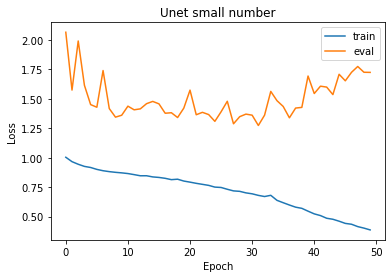

In [28]:
x=np.arange(len(train_losses))
plt.plot(x,train_losses,label='train')
plt.plot(x,eval_losses,label='eval')
plt.title('Unet small number')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

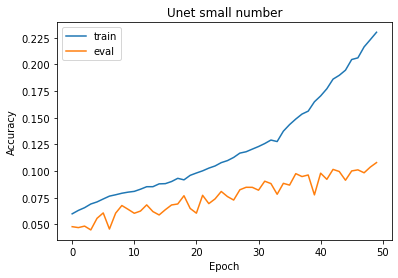

In [29]:
plt.plot(x,train_accs,label='train')
plt.plot(x,eval_accs,label='eval')
plt.title('Unet small number')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
num_figure=8
imgs=np.arange(num_figure)*10

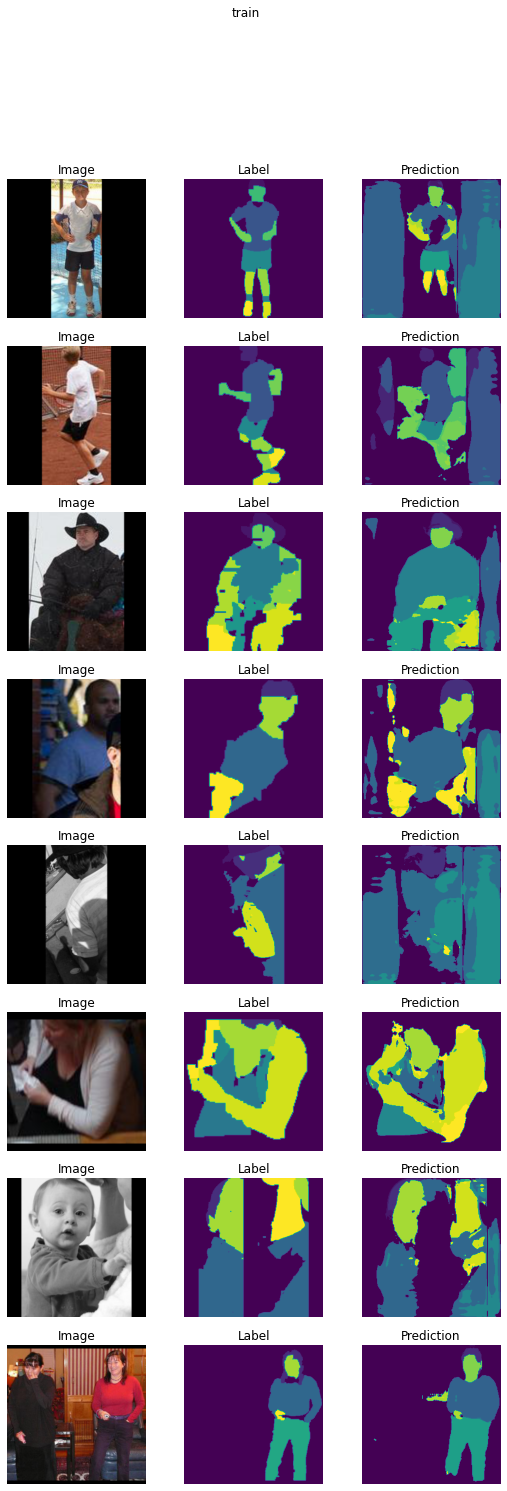

In [31]:
plt.figure(figsize=(9,24))
count=1
for i in imgs:
    
    img,label=train_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.title('Image')
    
    plt.axis('off')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    plt.imshow(label.numpy())
    plt.axis('off')
    plt.title('Label')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    img=torch.unsqueeze(img,dim=0)
    b_x=Variable(img).cuda()
    output=unet(b_x).to(torch.float64)
    output=torch.max(output,1)[1]
    plt.imshow(output.cpu().detach().numpy()[0])
    plt.title('Prediction')
    plt.axis('off')
    
    count+=1
plt.suptitle('train')    
plt.show()

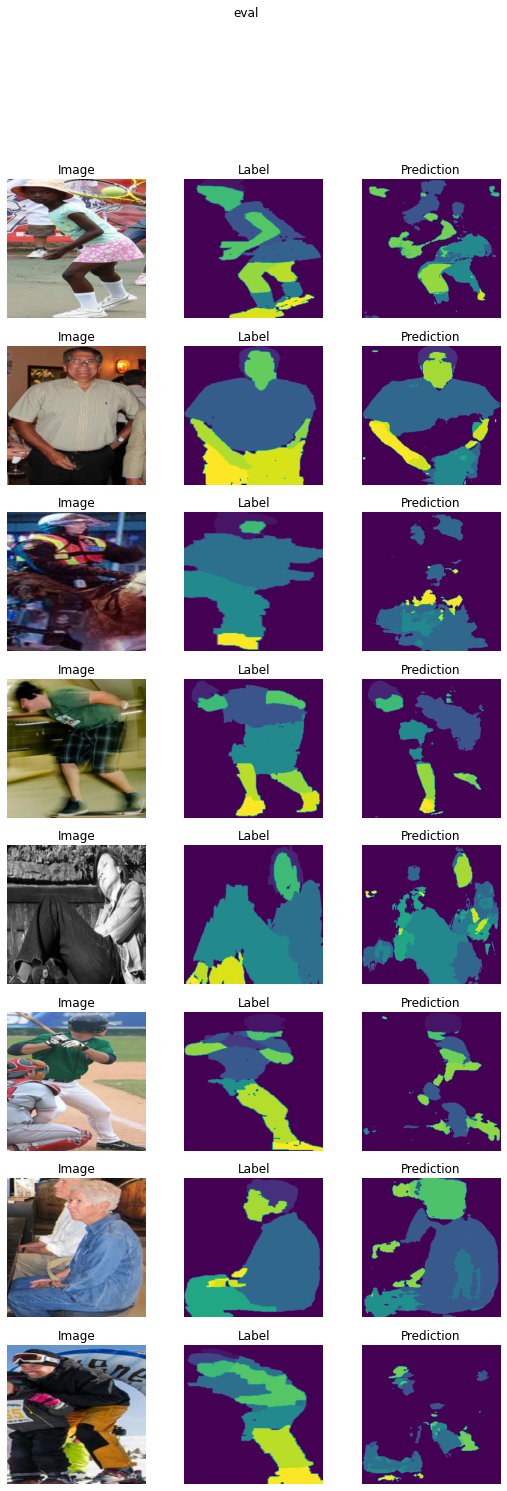

In [32]:
plt.figure(figsize=(9,24))
count=1
for i in imgs:
    
    img,label=eval_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.title('Image')
    
    plt.axis('off')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    plt.imshow(label.numpy())
    plt.title('Label')
    plt.axis('off')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    img=torch.unsqueeze(img,dim=0)
    b_x=Variable(img).cuda()
    output=unet(b_x).to(torch.float64)
    output=torch.max(output,1)[1]
    plt.imshow(output.cpu().detach().numpy()[0])
    plt.title('Prediction')
    plt.axis('off')
    
    count+=1
plt.suptitle('eval')    
plt.show()

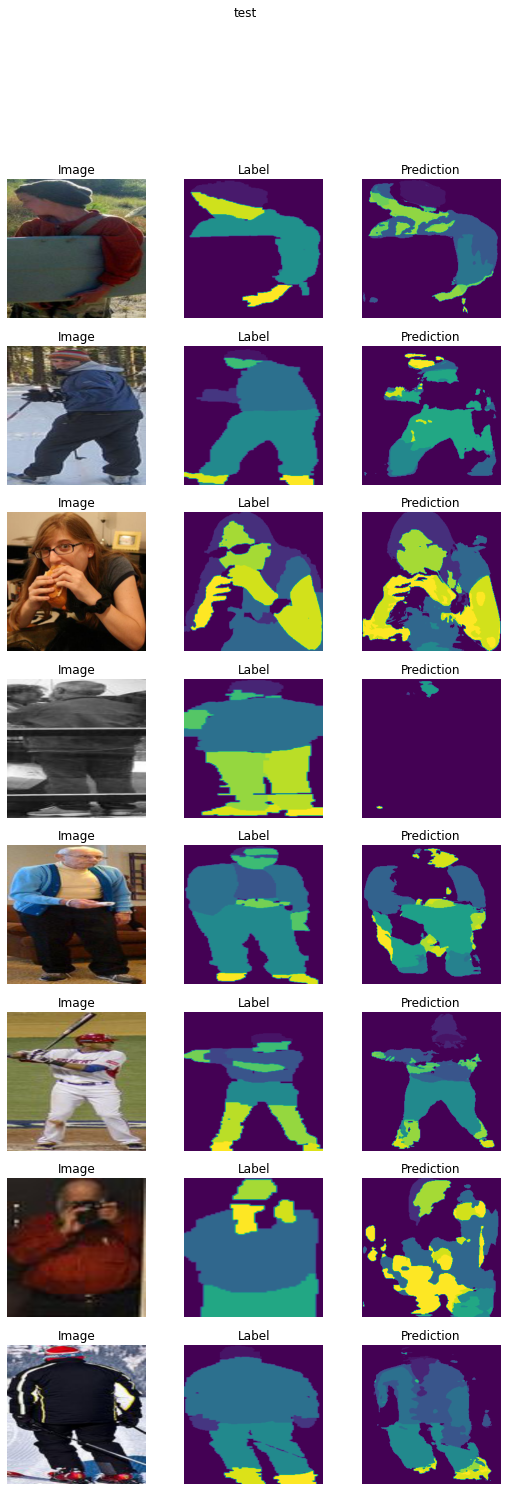

In [33]:
test_data=MyDataSet('test',test_transfrom)
plt.figure(figsize=(9,24))
count=1
for i in imgs:
    
    img,label=test_data.__getitem__(i)
    
    plt.subplot(num_figure,3,count)
    plt.imshow(np.transpose(img.numpy(),(1,2,0)))
    plt.title('Image')
   
    plt.axis('off')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    plt.imshow(label.numpy())
    plt.title('Label')
    plt.axis('off')
    count+=1
    
    
    plt.subplot(num_figure,3,count)
    img=torch.unsqueeze(img,dim=0)
    b_x=Variable(img).cuda()
    output=unet(b_x).to(torch.float64)
    output=torch.max(output,1)[1]
    plt.imshow(output.cpu().detach().numpy()[0])
    plt.title('Prediction')
    plt.axis('off')
    
    count+=1
plt.suptitle('test')    
plt.show()